In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from models import Model

/Users/I551393/Library/Caches/pypoetry/virtualenvs/tsf-ss25-timegpt-9SjHUXw4-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Undestanding

In [3]:
df = pd.read_csv('../../transformed_data/cleaned_australian_electricity_demand.csv')
df['ts'] = pd.to_datetime(df['ts'])
df = df.sort_values('ts').reset_index(drop=True)
df.rename(columns={"series_value": "y"}, inplace=True)
print("Length of the df: ", len(df))

Length of the df:  230736


2308


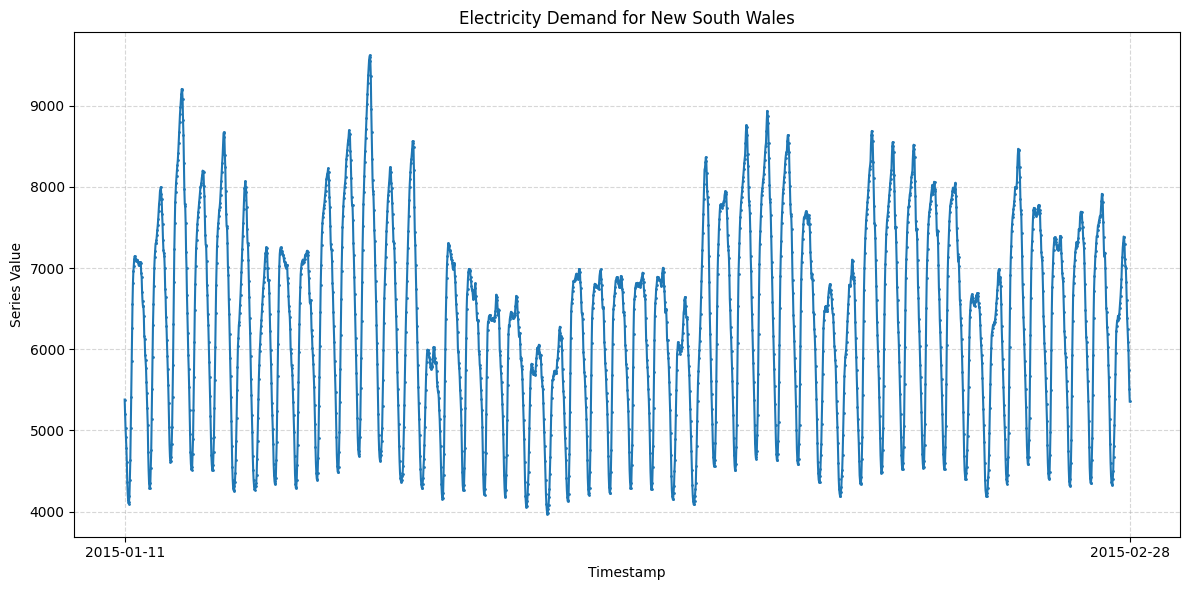

In [4]:
df_short = df[int(len(df) * 0.99):]
print(len(df_short))

start = df_short['ts'].min()
end = df_short['ts'].max()


plt.figure(figsize=(12, 6))
plt.plot(df_short['ts'], df_short['y'], marker='o', markersize=1)

# Start and End-Ticks
plt.xticks([start, end], [start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')])

plt.xlabel('Timestamp')
plt.ylabel('Series Value')
plt.title('Electricity Demand for New South Wales')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [5]:
# shortening the dataset
size = 10000 # length of the training dataset
df_recent = df.tail(size).copy()
train_ratio = 0.8
split_idx   = int(len(df_recent) * train_ratio)

df_train = df_recent.iloc[:split_idx].copy().reset_index(drop=True)
df_test  = df_recent.iloc[split_idx:].copy().reset_index(drop=True)

df_recent.head()

,ts,y
220736,2014-08-04 16:00:00,7171.267818
220737,2014-08-04 16:30:00,7540.809382
220738,2014-08-04 17:00:00,8135.479068
220739,2014-08-04 17:30:00,8919.192144
220740,2014-08-04 18:00:00,9194.300292


In [6]:
df_recent['ts'].diff().dropna().value_counts()

ts
0 days 00:30:00    9999
Name: count, dtype: int64

In [7]:
model = Model(df=df_recent)

Len = 10000 | duplicates = 0
Missing values (ts + y) = 0
Inferred frequency = 30min
Irregular 30min gaps = 0


# Baseline Model

# ARIMA

In [8]:
arima_result = model.auto_arima()
arima_result.head()

Starting ARIMA Training...

ARIMA Training Duration:  52.05993390083313


,ts,yhat
0,2015-02-24 20:00:00,6709.270370
1,2015-02-24 20:30:00,6415.872958
2,2015-02-24 21:00:00,6271.285959
3,2015-02-24 21:30:00,6046.012134
4,2015-02-24 22:00:00,5914.918104


# LSTM

# Prophet

In [9]:
# Forecast
model = Model(df_recent)
prophet_result = model.prophet()
prophet_result.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmp5chogp_u/yz_k8f1d.json
DEBUG:cmdstanpy:input tempfile: /var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmp5chogp_u/3ewwn8f4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/I551393/Library/Caches/pypoetry/virtualenvs/tsf-ss25-timegpt-9SjHUXw4-py3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26912', 'data', 'file=/var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmp5chogp_u/yz_k8f1d.json', 'init=/var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmp5chogp_u/3ewwn8f4.json', 'output', 'file=/var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmp5chogp_u/prophet_model00ugdcir/prophet_model-20250703113810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:38:10 - cmdstanpy - INFO - Chain [1] sta

Starting Prophet Training...



11:38:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Training duration:  0.4103569984436035


,ts,yhat
0,2015-02-24 20:00:00,7049.889074
1,2015-02-24 20:30:00,6871.186489
2,2015-02-24 21:00:00,6693.789454
3,2015-02-24 21:30:00,6517.231438
4,2015-02-24 22:00:00,6338.477245


# TimesFM

# TimeGPT

In [8]:
nixtla_result = model.time_gpt()
nixtla_result.head()

Nixtla DataFrame:                     ts            y unique_id
0 2014-08-04 16:00:00  7171.267818       id1
1 2014-08-04 16:30:00  7540.809382       id1
2 2014-08-04 17:00:00  8135.479068       id1
3 2014-08-04 17:30:00  8919.192144       id1
4 2014-08-04 18:00:00  9194.300292       id1


INFO:nixtla.nixtla_client:Happy Forecasting! :)
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...


True
Starting TimeGPT Training...



INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Nixtla Prediction Time:  1.774583101272583


,ts,yhat
0,2015-01-19 09:00:00,5691.4090
1,2015-01-19 09:00:00,5767.3354
2,2015-01-19 09:00:00,5925.8945
3,2015-01-19 09:00:00,6080.7217
4,2015-01-19 09:00:00,6198.6377


# Summary

## Metrics

In [11]:
# Calculate metrics for all models
models_metrics = {}

# ARIMA metrics
arima_mae = mean_absolute_error(df_test['y'], arima_result['yhat'])
arima_mape = mean_absolute_percentage_error(df_test['y'], arima_result['yhat'])
arima_mse = mean_squared_error(df_test['y'], arima_result['yhat'])
models_metrics['ARIMA'] = {'MAE': arima_mae, 'MAPE': arima_mape, 'MSE': arima_mse}

# Prophet metrics
prophet_mae = mean_absolute_error(df_test['y'], prophet_result['yhat'])
prophet_mape = mean_absolute_percentage_error(df_test['y'], prophet_result['yhat'])
prophet_mse = mean_squared_error(df_test['y'], prophet_result['yhat'])
models_metrics['Prophet'] = {'MAE': prophet_mae, 'MAPE': prophet_mape, 'MSE': prophet_mse}

# TimeGPT metrics
nixtla_mae = mean_absolute_error(df_test['y'], nixtla_result['yhat'])
nixtla_mape = mean_absolute_percentage_error(df_test['y'], nixtla_result['yhat'])
nixtla_mse = mean_squared_error(df_test['y'], nixtla_result['yhat'])
models_metrics['TimeGPT'] = {'MAE': nixtla_mae, 'MAPE': nixtla_mape, 'MSE': nixtla_mse}

# Display results
metrics_df = pd.DataFrame(models_metrics).T
print("Model Performance Metrics:")
print(metrics_df.round(4))

Model Performance Metrics:
              MAE    MAPE           MSE
ARIMA    283.6021  0.0460  1.254444e+05
Prophet  326.1597  0.0526  1.701888e+05
TimeGPT  890.1829  0.1566  1.113978e+06


## Visualization

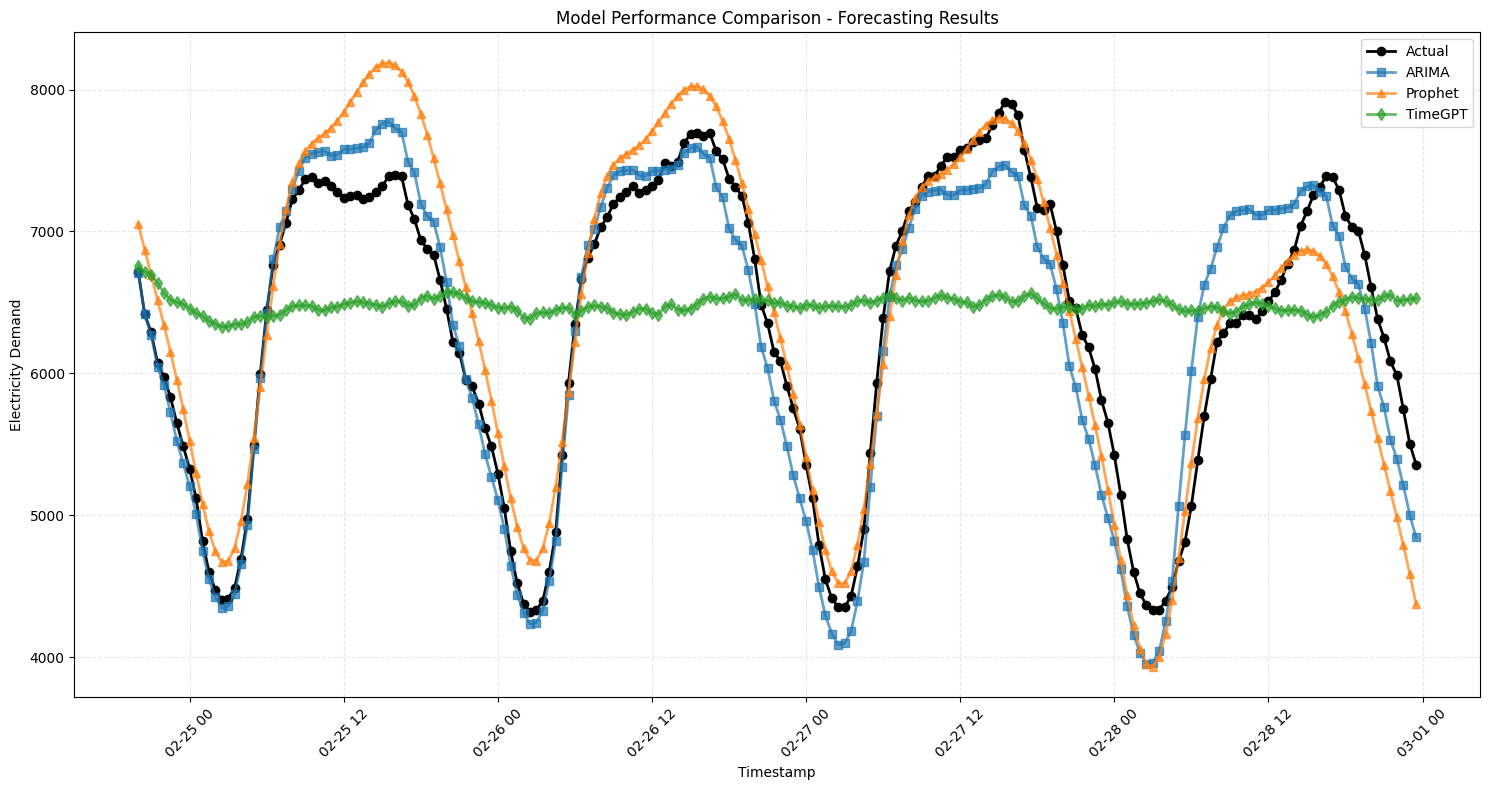

In [12]:
plt.figure(figsize=(15, 8))

# Plot actual values
plt.plot(df_test['ts'], df_test['y'], label='Actual', marker='o', linewidth=2, color='black')

# Plot ARIMA predictions (filter out NaN values)
arima_valid = arima_result.dropna()
plt.plot(arima_valid['ts'], arima_valid['yhat'], label='ARIMA', marker='s', linewidth=2, alpha=0.7)

# Plot Prophet predictions
plt.plot(prophet_result['ts'], prophet_result['yhat'], label='Prophet', marker='^', linewidth=2, alpha=0.7)

# Plot TimeGPT predictions
plt.plot(nixtla_result['ts'], nixtla_result['yhat'], label='TimeGPT', marker='d', linewidth=2, alpha=0.7)

plt.xlabel('Timestamp')
plt.ylabel('Electricity Demand')
plt.title('Model Performance Comparison - Forecasting Results')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()